# Regularization in Linear Model

In this notebook, we will see the limitations of linear regression models and the advantage of using regularized models instead.
So let's first started by getting some intuitions on regularized linear models.

## Intuitions on regularized linear models

* Linear models can also overfit
* Possible causes:
    * n_samples << n_features
    * Many uninformative features: fitting models with thousands of unrelated features can make linear models easily overfit any data

One solution would be to filter-out useless features:
* it's somewhat possible using automated feature selection methods
* However, it is not always easy to tell if a given decision should be included or not
* Or to use ridge regression instead of an unregularized regression such as: `LinearRegression`
* Ridge regression pulls the coefficients towards 0
* Large alpha --> more regularization
* Recommendation: always use ridge with a carefully tuned alpha

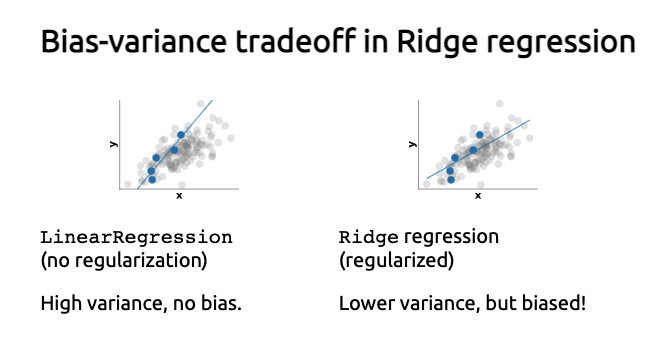

### Automated tuning for regularization

* It is possible to use cross-validation and the grid search procedure to tune the value of alpha for a given problem.
* For ridge regression it's also possible to use the RidgeCV class that can run a very efficient internal tuning procedure that can be significantly faster than running a traditional grid search.
* The selected value for the parameter alpha is stored as the attribute `model.alpha_` after calling fit.

### Regularization in logistic regression

* Logistic regression is regularized by default: `LogisticRegression(C=1)`
* It is controlled by the `C` parameter
* For a large value of c, the model puts more emphasis on the data points close to the frontier.
* On the contrary, for a low value of c, the model considers all the points.
* As with Ridge, the tradeoff controlled by the choice of c depends on your dataset and can be tuned using `LogisticRegressionCV` object.

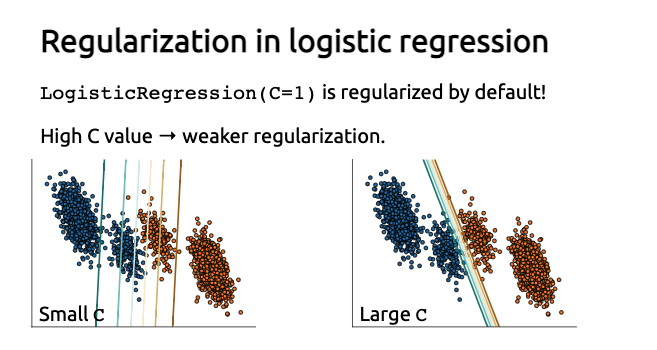